Let's first load the necessary packages and libraries

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from Graph_Generation.simple_graph_generation import create_sparse_connected_grid
from Graph_Generation.target_graph import create_fully_connected_target_graph
from Graph_Generation.visibility import line_of_sight_visibility
from Single_Agent.value_iteration import SuboptimalValueIteration

Let's generate the graph (a 2D grid looking graph)


At the moment we have the following graph features


Node Level: 

    - "type": "source", "target_unreached", "target_reached", "intermediate" 

    - "visible_edges": a map from each node to the visible edges 


Note that the node's position is accessed like a 2D array, rather than using an explicit position attribute


Edge Level: 

    - "distance": Euclidian distance of the edge 

    - "observed_edge" : boolean of whether or not the edge was observed 
    
    - "num_used" : an edge value function 

In [2]:
num_rows = 10
num_columns = 10
env_graph = create_sparse_connected_grid(num_rows, num_columns, 
                                         node_removal_fraction=0.1, 
                                         edge_removal_fraction=0.2,
                                         target_ratio = 0.1,
                                         seed=46)
env_graph = line_of_sight_visibility(env_graph, visibility_range=3)
target_graph = create_fully_connected_target_graph(env_graph)

Let's first visualize the environment graph

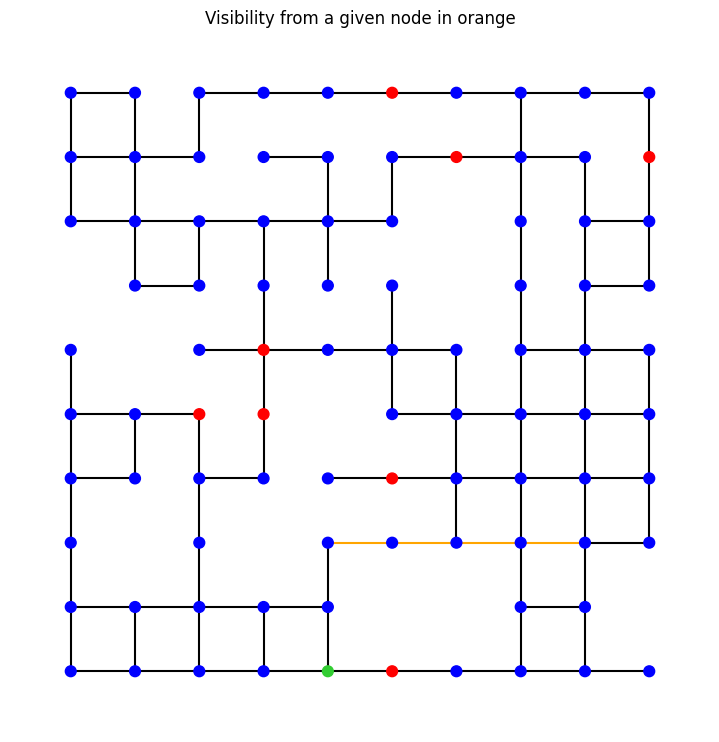

In [3]:
source_node = tuple([7,5]) # where to check visibility from 
visible_edges = env_graph.nodes[source_node]['visible_edges']

# Position nodes in a grid layout
pos = {(x, y): (y, -x) for x, y in env_graph.nodes()}

# Create a list of colors based on node attributes
color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in visible_edges:
        # Style for visible edges: orange
        edge_color.append('orange')
    else:
        # Style for invisible edges: black
        edge_color.append('black')

# Draw the graph with updated styles
plt.figure(figsize=(7, 7))
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map, 
    with_labels=False,
    node_size=60,
    width=1.5,
    edge_color=edge_color
)

plt.title("Visibility from a given node in orange")
plt.show()

Let's also visulize the target graph and the 'num_used' weights

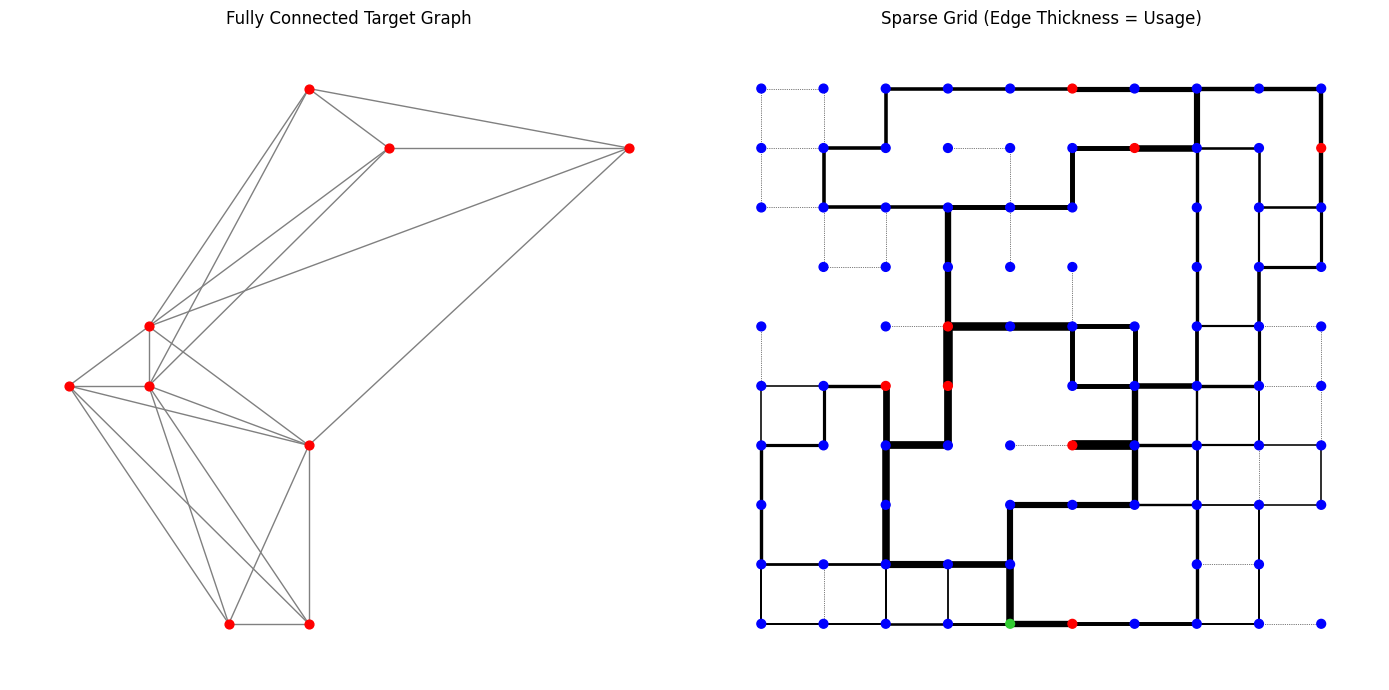

In [4]:
# --- 1. Prepare for Plotting ---

# Position nodes using the original graph so all nodes have a defined position
pos = {(x, y): (y, -x) for x, y in env_graph.nodes()}

color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  # Use a vibrant green for the source
    elif data["type"] == "target_unreached":
        color_map.append("red")
    else:
        color_map.append("blue")

# --- 2. Create Dynamic Edge Styles for the Sparse Grid ---

edge_widths = []
edge_styles = []
for u, v, data in env_graph.edges(data=True):
    num_used = data.get('num_used', 0)
    if num_used > 0:
        # Style for used edges: solid and thicker based on usage count
        edge_styles.append('solid')
        edge_widths.append(1.0 + 1.0 * num_used)  # Scaled for visibility
    else:
        # Style for unused edges: dotted and thin
        edge_styles.append('dotted')
        edge_widths.append(0.5)

# --- 3. Create the Side-by-Side Plot (in the new order) ---

# Create a figure and a set of subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# --- Plot 1: Fully Connected Target Graph (NOW on the left axis) ---
axes[0].set_title("Fully Connected Target Graph")
nx.draw(
    target_graph,
    pos=pos,
    ax=axes[0],  # Draw on the left subplot
    node_color="red",
    with_labels=False,
    node_size=40,
    width=1.0,
    edge_color='grey'
)

# --- Plot 2: Original Sparse Grid with Usage (NOW on the right axis) ---
axes[1].set_title("Sparse Grid (Edge Thickness = Usage)")
nx.draw(
    env_graph,
    pos=pos,
    ax=axes[1],  # Draw on the right subplot
    node_color=color_map,
    with_labels=False,
    node_size=40,
    width=edge_widths,  # Use the dynamic widths
    style=edge_styles   # Use the dynamic styles
)

plt.tight_layout()
plt.show()

Let's now run value iteration to find the optimal path given our reward function

In [5]:
starting_node = [node for node, data in env_graph.nodes(data=True) if data.get("type") == "source"][0]

value_iteration = SuboptimalValueIteration(env_graph=env_graph, s0=starting_node, gamma=0.5)

trajectory = []
trajectory = value_iteration.run()

Initial unreached targets: [(0, 5), (1, 6), (1, 9), (4, 3), (5, 2), (5, 3), (6, 5), (9, 5)]
Time step 1: Moved to (9, 5), Remaining targets: 7
Time step 2: Moved to (9, 4), Remaining targets: 7
Time step 3: Moved to (8, 4), Remaining targets: 7
Time step 4: Moved to (7, 4), Remaining targets: 7
Time step 5: Moved to (7, 5), Remaining targets: 7
Time step 6: Moved to (7, 6), Remaining targets: 7
Time step 7: Moved to (6, 6), Remaining targets: 7
Time step 8: Moved to (6, 5), Remaining targets: 6
Time step 9: Moved to (6, 6), Remaining targets: 6
Time step 10: Moved to (5, 6), Remaining targets: 6
Time step 11: Moved to (4, 6), Remaining targets: 6
Time step 12: Moved to (4, 5), Remaining targets: 6
Time step 13: Moved to (4, 4), Remaining targets: 6
Time step 14: Moved to (4, 3), Remaining targets: 5
Time step 15: Moved to (5, 3), Remaining targets: 4
Time step 16: Moved to (6, 3), Remaining targets: 4
Time step 17: Moved to (6, 2), Remaining targets: 4
Time step 18: Moved to (5, 2), Re

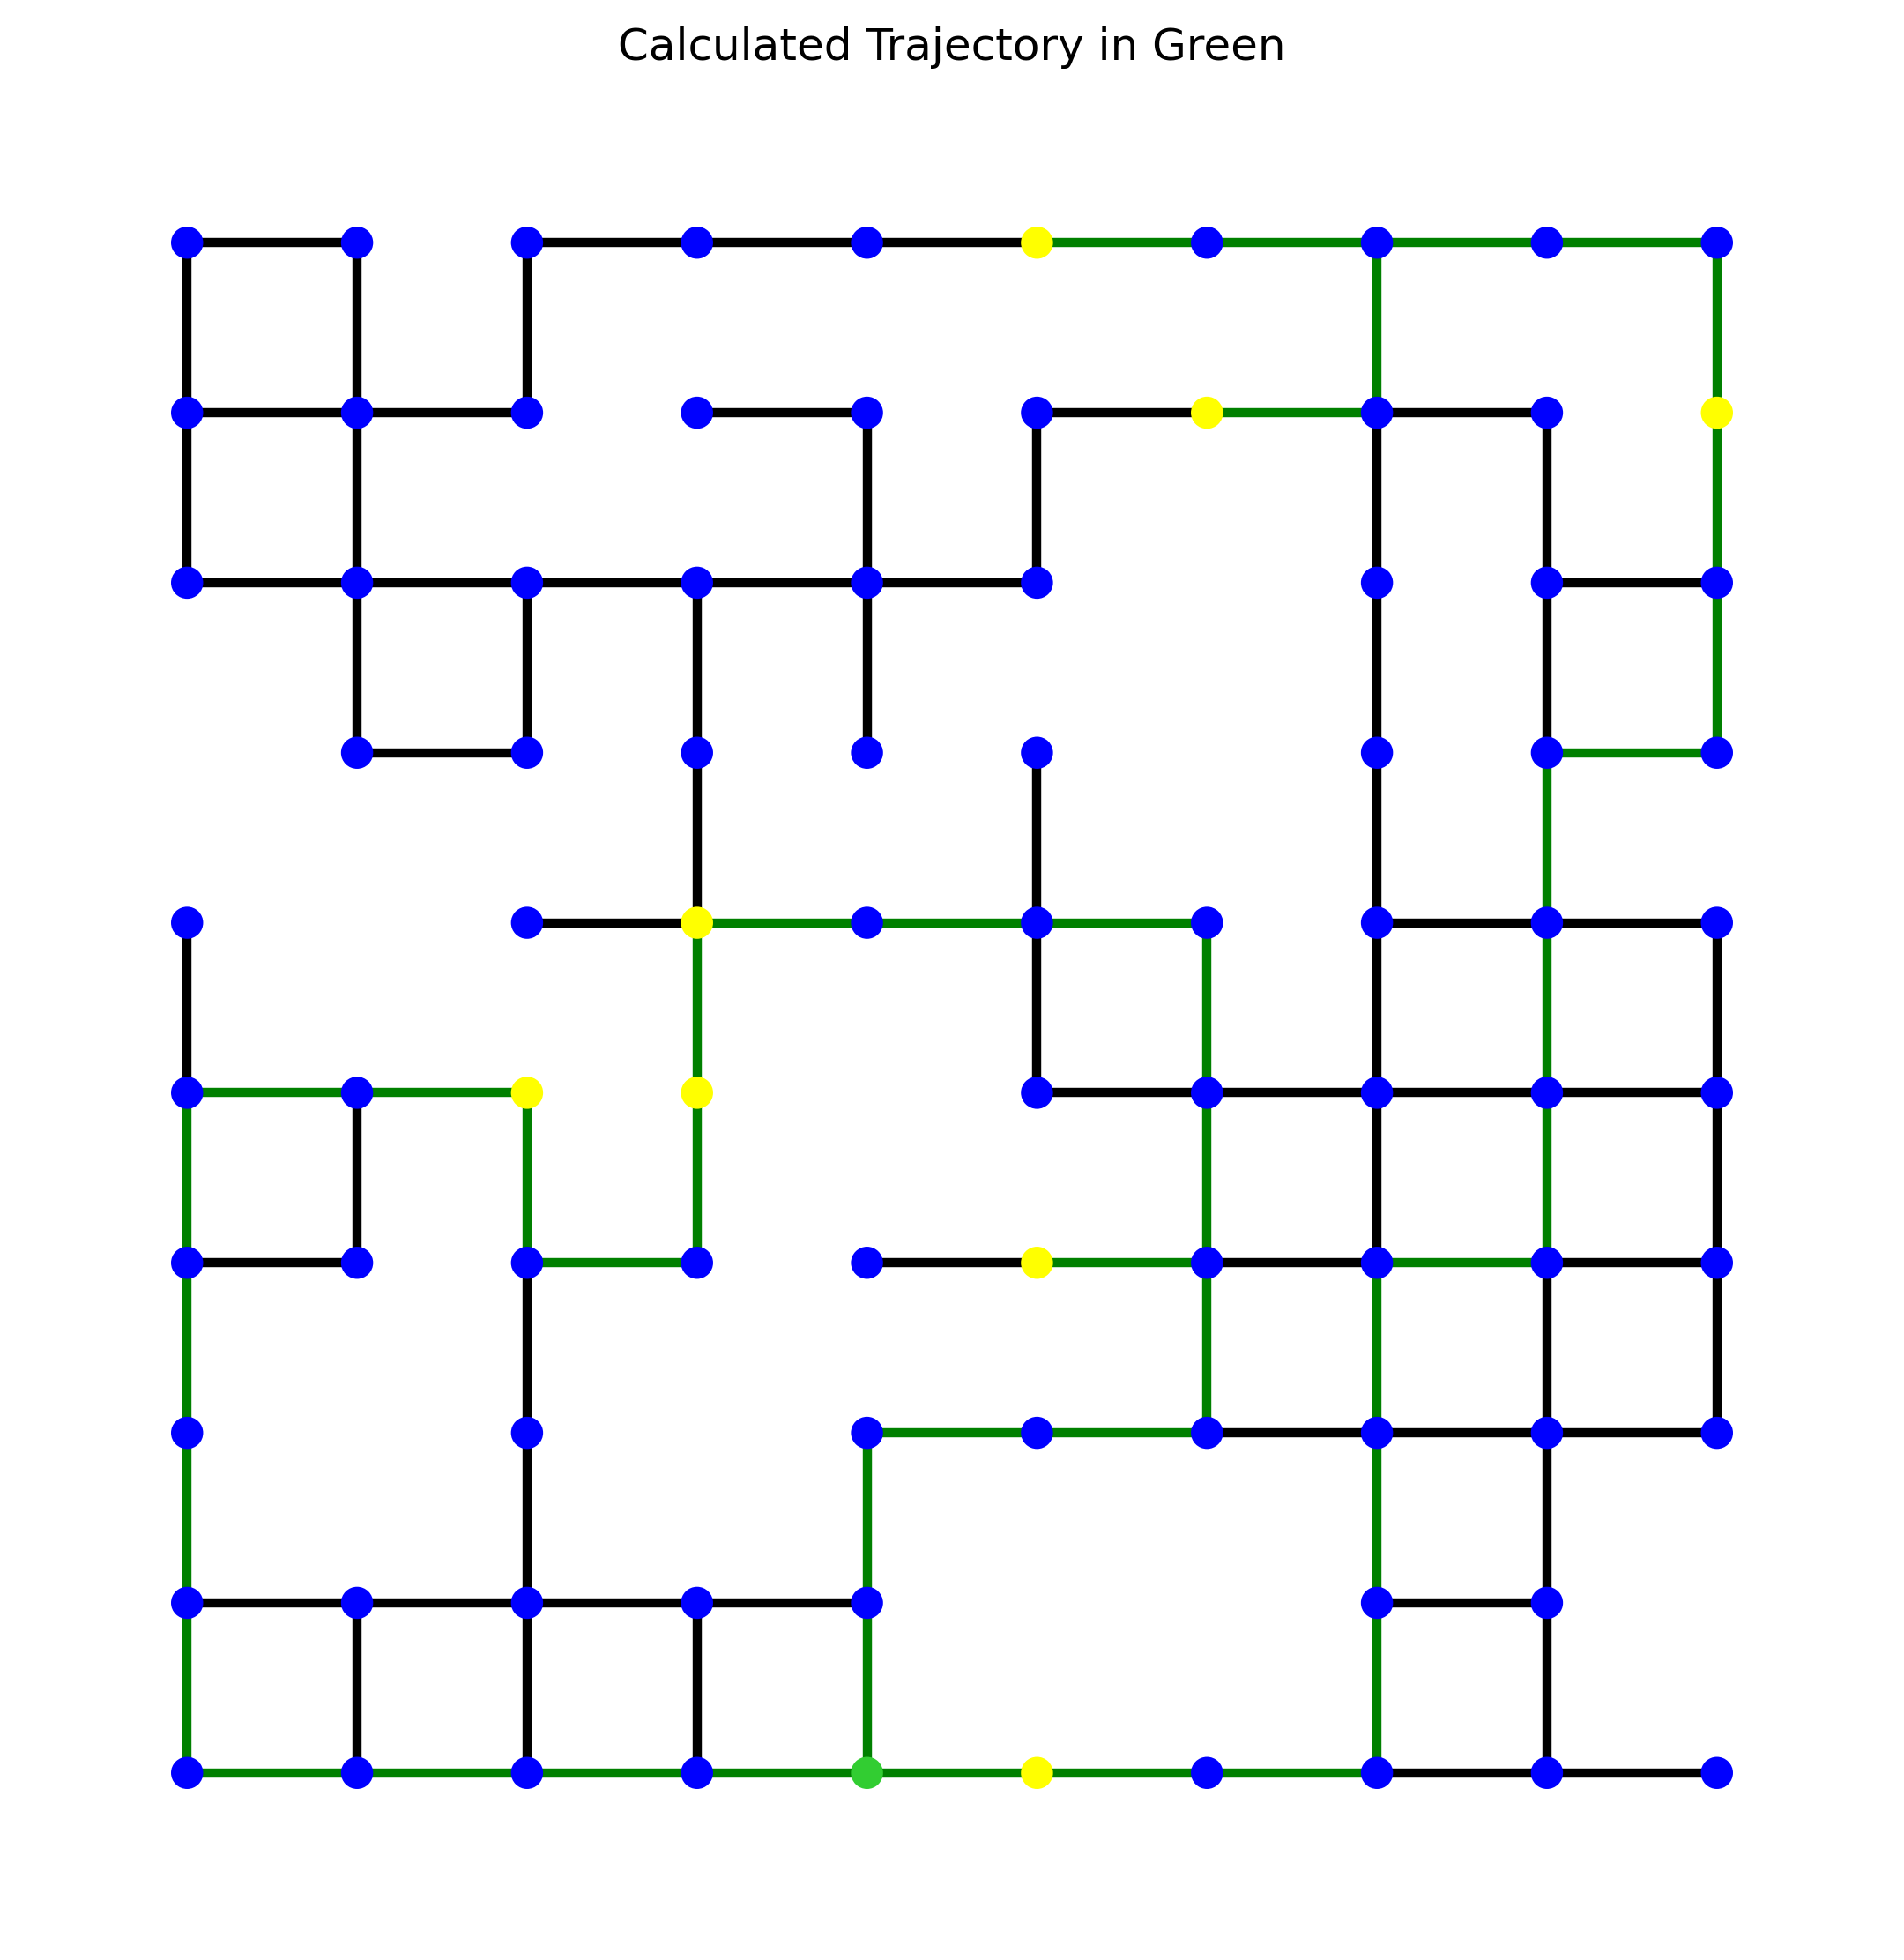

In [6]:
trajectory_edges = {tuple(sorted((u, v))) for u, v in trajectory}

# Position nodes in a grid layout
pos = {(x, y): (y, -x) for x, y in env_graph.nodes()}

# Create a list of colors based on node attributes
color_map = []
for node, data in env_graph.nodes(data=True):
    if data["type"] == "source":
        color_map.append("limegreen")  
    elif data["type"] == "target_reached":
        color_map.append("yellow")
    elif data["type"] == "target_unreached":
        color_map.append("red")  
    else:
        color_map.append("blue")

edge_color = []
for u, v, data in env_graph.edges(data=True):
    edge_tuple = tuple(sorted((u, v)))
    if edge_tuple in trajectory_edges:
        edge_color.append('green')
    else:
        # Style for invisible edges: black
        edge_color.append('black')

node_labels = {s: f"{v:.2f}" for s, v in value_iteration.V_t.items()}

# Draw the graph with updated styles
plt.figure(figsize=(7, 7), dpi=300)
nx.draw(
    env_graph,
    pos=pos,
    node_color=color_map,
    with_labels=False, 
    labels=node_labels,
    node_size=60,
    width=2.5,
    edge_color=edge_color,
)

plt.title("Calculated Trajectory in Green")
plt.show()